<center><FONT SIZE="+3"> Pairing problem for arbitrary number of pairs and levels </FONT><br>
<FONT SIZE="+1">Group 9: Xinyue Diao, Chenyang Niu, Lars Zurek </FONT></center>

In [1]:
#this file computes the pairing matrix for a given number of pairs and levels and solves the eigenvalue problem
import numpy as np
from numpy import linalg as la
from sympy.utilities.iterables import multiset_permutations as mup
import matplotlib.pyplot as plt
import math
import array

In [2]:
def binomial(a,b):
    return math.factorial(a)/(math.factorial(a-b)*math.factorial(b))

<FONT SIZE="+2"> Creating array of Slater determinants in 'bit-like' representation </FONT>

In [3]:
def make_slater_determinants(no_of_pairs,no_of_levels):
    no_of_slater_determinants = int(binomial(no_of_levels, no_of_pairs)) #number of Slater determinants
    creation_array = np.concatenate((np.ones(no_of_pairs), np.zeros(no_of_levels-no_of_pairs))) #Array with ones 
    #for pairs, other levels are filled with zeros
    slater_determinants = np.zeros(shape=(no_of_slater_determinants,no_of_levels))
    i = 0
    for p in mup(creation_array):
        slater_determinants[i] = p #Slater determinants are set as all distinct permutations of the creationarray
        i += 1
    return no_of_slater_determinants, slater_determinants

In [4]:
make_slater_determinants(2,4)

(6, array([[0., 0., 1., 1.],
        [0., 1., 0., 1.],
        [0., 1., 1., 0.],
        [1., 0., 0., 1.],
        [1., 0., 1., 0.],
        [1., 1., 0., 0.]]))

<FONT SIZE="+2"> Calculating pairing matrix elements by comparing number of occupied levels</FONT>

In [5]:
def pairing_matrix_element(no_of_pairs,no_of_levels,slater_det_1,slater_det_2,d,g):
    no_of_same_levels = np.dot(slater_det_1,slater_det_2) #this gives the number levels that are occupied in the 
    #bra-state as well as in the ket-state
    if no_of_same_levels == no_of_pairs: #diagonal matrix elements
        single_particle_energy_factor = sum(np.nonzero(slater_det_1)[0])
        returnvalue = 2*single_particle_energy_factor*d - no_of_pairs*g/2
    elif no_of_same_levels == no_of_pairs - 1: #matrix elements where bra and ket differ in one pair
        returnvalue = -g/2
    else: #Slater-Condon rule
        returnvalue = 0
    return returnvalue

In [6]:
pairing_matrix_element(2,4,[1,0,0,1],[1,0,1,0],1,.3)

-0.15

<FONT SIZE="+2"> Generating pairing matrix</FONT>

In [7]:
def make_pairing_matrix(no_of_pairs,no_of_levels,d,g):
    matrix_size, slater_determinants = make_slater_determinants(no_of_pairs,no_of_levels) #setting up necessary 
    #Slater determinants
    pairing_matrix = np.zeros(shape=(matrix_size,matrix_size)) 
    for i in range(matrix_size):
        for j in range(i,matrix_size):
            pairing_matrix[-i-1,-j-1] = pairing_matrix_element(no_of_pairs,no_of_levels,slater_determinants[i],
                                                               slater_determinants[j],d,g) #matrix elements are 
            #filled up from the bottom such that the lowest states are placed in the beginning
    pairing_matrix = pairing_matrix + pairing_matrix.T - np.diag(pairing_matrix.diagonal()) #makes matrix symmetric 
    #from up-right triangle
    return pairing_matrix

In [8]:
make_pairing_matrix(2,4,1,.3)

array([[ 1.7 , -0.15, -0.15, -0.15, -0.15,  0.  ],
       [-0.15,  3.7 , -0.15, -0.15,  0.  , -0.15],
       [-0.15, -0.15,  5.7 ,  0.  , -0.15, -0.15],
       [-0.15, -0.15,  0.  ,  5.7 , -0.15, -0.15],
       [-0.15,  0.  , -0.15, -0.15,  7.7 , -0.15],
       [ 0.  , -0.15, -0.15, -0.15, -0.15,  9.7 ]])

<FONT SIZE="+2"> Solving eigenvalue problem and plotting stuff</FONT>

In [9]:
def solve_eigenvalues(no_of_pairs,no_of_levels,d,g_min=-1,g_max=1,no_of_points=21):  
    matrix_size = int(binomial(no_of_levels, no_of_pairs))    
    g_array = np.linspace(g_min,g_max,no_of_points) #values of g for which the problem is solved
    g_mat_eigenvalues = np.zeros(shape=(no_of_points,matrix_size)) #setting up other arrays
    g_mat_eigenvalues_sorted = np.zeros(shape=(no_of_points,matrix_size))
    g_mat_gs_correlation_energy = np.zeros(no_of_points)
    g_mat_eigenvectors = np.zeros(shape=(no_of_points,matrix_size,matrix_size))
    g_mat_ground_state_eigenvector_first_components = np.zeros(no_of_points)
    
    for x in range(no_of_points): #solving the eigenvalue problems
        g_mat_eigenvalues[x], g_mat_eigenvectors[x] = la.eig(make_pairing_matrix(no_of_pairs,no_of_levels,d,
                                                                                 g_array[x]))
        g_mat_eigenvalues_sorted[x] = np.sort(g_mat_eigenvalues[x])
        g_mat_gs_correlation_energy[x] = g_mat_eigenvalues_sorted[x,0]-(make_pairing_matrix(no_of_pairs,no_of_levels,
                                                                                            d,g_array[x])[0,0]) 
             
        for i in range(matrix_size): #sort eigenvectors similar as eigenvalues to identify ground state
            if g_mat_eigenvalues_sorted[x,0] == g_mat_eigenvalues[x,i]:
                g_mat_ground_state_eigenvector_first_components[x] = abs(g_mat_eigenvectors[x,0,i])
                break
    
    plt.figure(figsize=(8,5)) #doing all the plots
    plt.xlabel(r'Interaction strength $g$', fontsize=14)
    plt.ylabel(r'Eigenvalues', fontsize=14)    
    plt.plot(g_array,g_mat_eigenvalues_sorted,"-*")
    plt.show() 
    #plt.savefig("eigenvalues.pdf")
    
    plt.figure(figsize=(8,5))
    plt.xlabel(r'Interaction strength $g$', fontsize=14)
    plt.ylabel(r'Correlation energy', fontsize=14)    
    plt.plot(g_array,g_mat_gs_correlation_energy,"-*")
    plt.show() 
    #plt.savefig("corr_energy.pdf")
    
    plt.figure(figsize=(8,5))
    plt.xlabel(r'Interaction strength $g$', fontsize=14)
    plt.ylabel(r'Strength of lowest SD in GS', fontsize=14)
    plt.plot(g_array,g_mat_ground_state_eigenvector_first_components,"-*")
    plt.show() 
    #plt.savefig("gs_strength.pdf")   

<FONT SIZE="+2"> 1 pair in 2 levels</FONT>

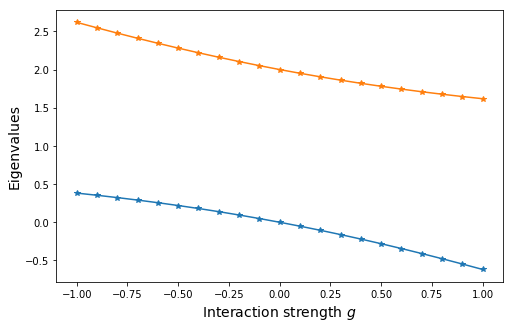

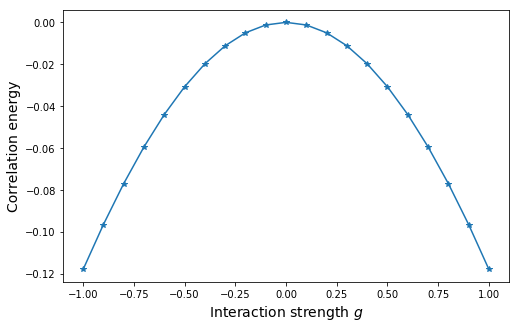

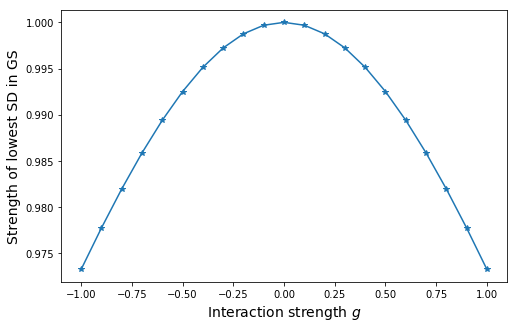

In [10]:
solve_eigenvalues(1,2,1)

<FONT SIZE="+2"> 2 pairs in 4 levels</FONT>

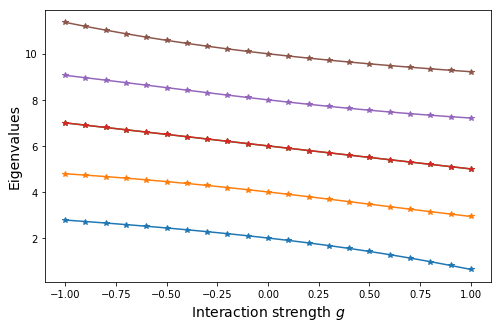

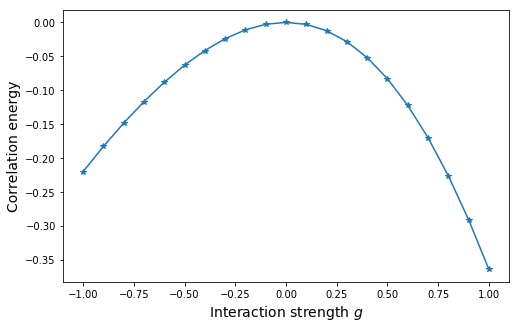

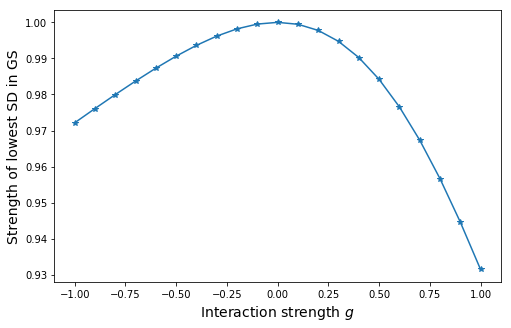

In [11]:
solve_eigenvalues(2,4,1)

<FONT SIZE="+2"> 4 pairs in 9 levels</FONT>

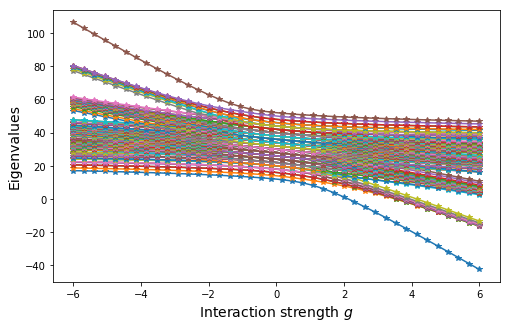

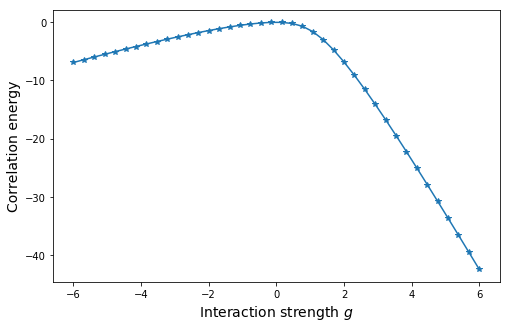

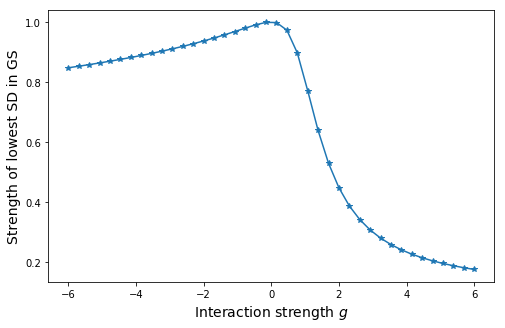

In [12]:
solve_eigenvalues(4,9,1,-6,6,40)